# Peer-graded Assignment: Эксперименты с моделью

На прошлой неделе вы поучаствовали в соревновании на kaggle и, наверняка, большинство успешно справилось с прохождением baseline, а значит пора двигаться дальше - заняться оптимизацией модели, провести серию экспериментов и построить сильное финальное решения.

В этом задании вам нужно провести ряд эскпериментов, оценить качество полученных в процессе экспериментирования моделей и выбрать лучшее решение. 

Задание будет оцениваться на основании загруженного jupyther notebook и развернутых ответов на поставленные вопросы.

### Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import learning_curve, StratifiedKFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from imblearn.under_sampling import TomekLinks, OneSidedSelection
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
data_train = pd.read_csv('orange_small_churn_train_data.csv')
data_test = pd.read_csv('orange_small_churn_test_data.csv')

In [3]:
data_train.shape

(18299, 232)

In [4]:
num_col = data_train.columns[1:191]
cat_col = data_train.columns[191:-1]

### Начальная предобработка
Создадим функцию для заполнения пропущенных значений.

In [19]:
def fill_missing_values(df):
    df_num = df[num_col].fillna(0) # среди числовых признаков заменим пропуски нулевыми значениями
    df_cat = df[cat_col].fillna("NA", axis=0) # для категориальных признаков заменим пропуски на отдельную категорию "NA"
    df = pd.concat([df.ID, df_num, df_cat, df.labels], axis=1)
    return df

В качестве hold-out dataset буду использовать выборку из тестовой части предыдущего задания:

In [91]:
df_num = data_test[num_col].fillna(0) # среди числовых признаков заменим пропуски нулевыми значениями
df_cat = data_test[cat_col].fillna("NA", axis=0) 
df_test = pd.concat([data_test.ID, df_num, df_cat], axis=1)

In [92]:
X_test = df_test.drop(['ID'], axis=1)

Удаление последнего неразмеченного объекта:

In [5]:
data_train = data_train.drop([18298], axis=0)

## Инструкции

### 1\. Начнем с простого. Давайте оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Постройте кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратите внимание на sklearn.model_selection.learning_curve

In [17]:
df_train = fill_missing_values(data_train) # заполнение пропусков

In [25]:
estimator = CatBoostClassifier(iterations=300, learning_rate=0.1, depth=2, cat_features=cat_col, verbose=False)
X = df_train.drop(['ID', 'labels'], axis=1)

In [19]:
y = data_train.labels

In [15]:
cv = StratifiedKFold(shuffle=True)

In [41]:
train_sizes, train_scores, test_scores = learning_curve(estimator,
                                                        X, y,
                                                        train_sizes = np.linspace(0.1, 1, 10),
                                                        cv=cv, scoring='roc_auc')

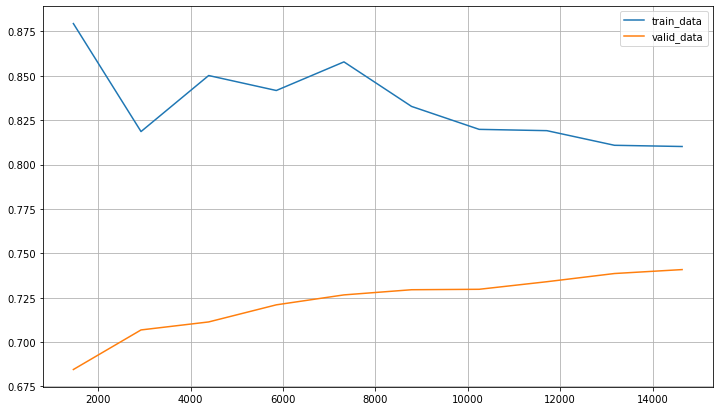

In [51]:
plt.figure(figsize=(12, 7))

plt.plot(train_sizes, train_scores.mean(axis=1), label='train_data')
plt.plot(train_sizes, test_scores.mean(axis=1), label='valid_data')
plt.legend()
plt.grid(True)

Анализируя графики, можно заметить, что при маленькой выборке модель сильно переобучается. С ростом выборки качество на валидационной части начинает увеличиваться, а на обучающей скорее падает, чем растет. Из этого можно сделать вывод, что для построения качественной модели нам нужны все объекты обучающей выборки.

### 2\. Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Давайте попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

#### 2.1\. Задайте веса объектам так, чтобы соотношение классов с учетом весов объектов изменилось. Попробуйте не менее трёх различных вариантов весов. Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y)

In [7]:
churn = data_train[data_train.labels == 1].shape[0] # число клиентов класса "отток"
not_churn = data_train[data_train.labels == -1].shape[0] # число клиентов класса "не отток"

In [8]:
all_ = data_train.shape[0] # число всех клиентов

Первый вариант:

In [58]:
class_weights = [1, not_churn / churn] # CatBoostClassifier имеет атрибут class_weights
model = CatBoostClassifier(iterations=300, learning_rate=0.1, depth=2, class_weights=class_weights)
model.fit(X_train, y_train, cat_features=cat_col, eval_set=(X_valid, y_valid), verbose=False)

In [60]:
roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

0.7940065987909368

In [61]:
roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])

0.744335168524238

In [69]:
ans = pd.DataFrame({'ID': data_test.ID,  'result': model.predict_proba(X_test)[:, 1]})
ans.to_csv('kaggle.csv', index=False)
# Качество на тесте получилось 0.7153

Второй вариант:

In [75]:
class_weights = [churn / all_, not_churn / all_]
model = CatBoostClassifier(iterations=300, learning_rate=0.1, depth=2, class_weights=class_weights)
model.fit(X_train, y_train, cat_features=cat_col, eval_set=(X_valid, y_valid), verbose=False)

In [76]:
roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

0.8107016095815475

In [77]:
roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])

0.7453363770645898

In [78]:
ans = pd.DataFrame({'ID': data_test.ID,  'result': model.predict_proba(X_test)[:, 1]})
ans.to_csv('kaggle.csv', index=False)
# Качество на тесте 0.7145

Третий вариант:

In [79]:
class_weights = [all_ / (2 * not_churn), all_ / (2 * churn)]
model = CatBoostClassifier(iterations=300, learning_rate=0.1, depth=2, class_weights=class_weights)
model.fit(X_train, y_train, cat_features=cat_col, eval_set=(X_valid, y_valid), verbose=False)

In [80]:
roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

0.8131235305033186

In [81]:
roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])

0.7489781119914058

In [82]:
ans = pd.DataFrame({'ID': data_test.ID,  'result': model.predict_proba(X_test)[:, 1]})
ans.to_csv('kaggle.csv', index=False)
# Качество на тесте 0.71557

При разных вариантах задания весов качество классификации сильно не меняется. Однако третий вариант с точки зраения качества является самым оптимальным. В этом варианте реализован баланс классов как в sklearn.linear_model.LogisticRegression.

#### 2.2\. Примените к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуйте не менее трёх различных вариантов undersampling (варианты могут отличаться как по количество отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

1 вариант (Random Undersampling)

In [25]:
def undersampling(df):
    y_1 = df[df.labels == 1] # клиенты класса "отток"
    y_0 = df[df.labels == -1] # клиенты класса "не отток"
    rand_ind = np.random.choice(y_0.index, churn) # рандомное сэмплирование ID клиентов класса "не отток" в количестве 
                                                  # равном числу клиентов класса "отток"
    new_y_0 = y_0.loc[rand_ind] # выбранные рандомно клиенты класса "не отток"
    return pd.concat([y_1, new_y_0], axis=0)

In [27]:
X = undersampling(df_train).drop(['ID', 'labels'], axis=1)
y = undersampling(df_train).labels
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y)
model = CatBoostClassifier(iterations=300, learning_rate=0.1, depth=2)
model.fit(X_train, y_train, cat_features=cat_col, eval_set=(X_valid, y_valid), verbose=False)

In [28]:
roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

0.8849288965154594

In [29]:
roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])

0.7399999999999998

In [30]:
ans = pd.DataFrame({'ID': data_test.ID,  'result': model.predict_proba(X_test)[:, 1]})
ans.to_csv('kaggle.csv', index=False)
# Качество на тесте получилось 0.69178

2 вариант (Поиск связей Томека)

Метод состоит в поиске элементов противоположного класса на близком расстоянии. Это обеспечивает более точную классификацию.
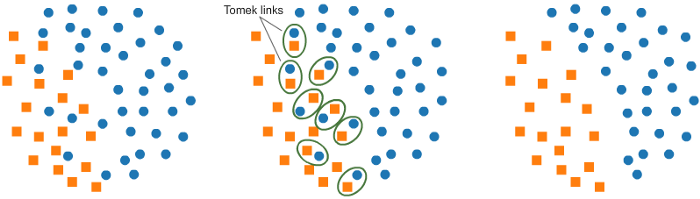

In [49]:
tl = TomekLinks(sampling_strategy='majority') # готовая реализация поиска связей Томека
X = df_train.drop(['ID', 'labels'], axis=1)
encoder = LabelEncoder()
for column in cat_col:
    X[column] = encoder.fit_transform(X[column]) # кодируем с помощью LabelEncoder категориальные признаки, так
                                                 # как поиск связей Томека использует расстояние между векторами
y = df_train.labels
X_tl, y_tl = tl.fit_sample(X, y)
X_train, X_valid, y_train, y_valid = train_test_split(X_tl, y_tl, test_size=0.2, stratify=y_tl)
model = CatBoostClassifier(iterations=300, learning_rate=0.1, depth=2)
model.fit(X_train, y_train, cat_features=cat_col, eval_set=(X_valid, y_valid), verbose=False)

In [50]:
roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

0.7969085331332043

In [51]:
roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])

0.7548158223455933

In [54]:
for column in cat_col:
    X_test[column] = LabelEncoder().fit_transform(X_test[column])
ans = pd.DataFrame({'ID': data_test.ID,  'result': model.predict_proba(X_test)[:, 1]})
ans.to_csv('kaggle.csv', index=False)
# Качество на тесте получилось 0.69332

3 вариант (Односторонний сэмплинг)

In [80]:
X = df_train.drop(['ID', 'labels'], axis=1)
for column in cat_col:
    X[column] = LabelEncoder().fit_transform(X[column])
y = df_train.labels
oss = OneSidedSelection(sampling_strategy='majority') # готовая реализация CNN
X_oss, y_oss = oss.fit_sample(X, y)
X_train, X_valid, y_train, y_valid = train_test_split(X_oss, y_oss, test_size=0.2, stratify=y_oss)
model = CatBoostClassifier(iterations=300, learning_rate=0.1, depth=2)
model.fit(X_train, y_train, cat_features=cat_col, eval_set=(X_valid, y_valid), verbose=False)

In [81]:
roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

0.7861651348247674

In [82]:
roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])

0.7220367640924386

In [84]:
ans = pd.DataFrame({'ID': data_test.ID,  'result': model.predict_proba(X_test)[:, 1]})
ans.to_csv('kaggle.csv', index=False)
# Качество на тесте получилось 0.68127

При разных вариантах Undersampling результаты классификации сильно не меняются. Однако можно четко выделить метод поиска связей Томека, который дает лучшее качество на тестовой выборке. 

В целом задание весов на тестовой выборке дает качество лучше, чем Undersampling. Поэтому далее будем использовать задание весов.

### 3\. Теперь перейдем к работе с признаками. Ранее вы реализовали несколько стратегий для обработки пропущенных значений. Сравните эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?
В данной задаче нужно заполнить пропуска как для числовых, так и для категориальных. Ранее в предыдущих заданиях было рассмотрено множество различных способов обработки пропущенных значений. В данном блоке рассмотрю 2 способа заполнения пропусков у числовых признаков (нулевыми значениями и значениями, которые сильно отличаются от всех типичных значений признака) и 2 способа заполнения категориальных признаков (новая категория "NA" и самым частым значением в столбце). Комбинируя полученные способы, получится 4 варианта обработки пропущенных значений.

Первый вариант: числовые признаки заполняются нулями, а категориальные новой категорией NA. Функция заполнения была написана выше.

In [9]:
class_weights = [all_ / (2 * not_churn), all_ / (2 * churn)]

In [88]:
model = CatBoostClassifier(iterations=300,
                           learning_rate=0.1,
                           depth=2,
                           class_weights=class_weights,
                           cat_features=cat_col,
                           verbose=False)
X = df_train.drop(['ID', 'labels'], axis=1)
y = df_train.labels
score = cross_val_score(model, X, y, scoring='roc_auc', cv=cv).mean()
print('Площадь под ROC кривой %f' % score)

Площадь под ROC кривой 0.736024


In [94]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y)
model.fit(X_train, y_train, eval_set=(X_valid, y_valid))
ans = pd.DataFrame({'ID': data_test.ID,  'result': model.predict_proba(X_test)[:, 1]})
ans.to_csv('kaggle.csv', index=False)
# Качество на тесте получилось 0.71595

Второй вариант: числовые признаки заполняются нулями, а категориальные самым частым значением в столбце.

In [7]:
drop_col = data_train.count(axis=0)[data_train.count(axis=0) == 0].index # столбцы, у которых все значения пропущены

In [26]:
data_train = data_train.drop(drop_col, axis=1)

In [148]:
def fill_missing_values(df):
    num_columns = [c for c in num_col if c in df.columns]
    df_num = df[num_columns].fillna(0)
    df_describe = df.describe(include=[object])
    cat_columns = [c for c in cat_col if c in df.columns]
    for c in cat_columns:
        df[c] = df[c].fillna(df_describe[c]['top'])
    X = pd.concat([df.ID, df_num, df[cat_columns]], axis=1)
    return X

In [132]:
X = fill_missing_values(data_train).drop(['ID'], axis=1)

In [12]:
cat_columns = [c for c in cat_col if c in data_train.columns]

In [140]:
model = CatBoostClassifier(iterations=300,
                           learning_rate=0.1,
                           depth=2,
                           class_weights=class_weights,
                           cat_features=cat_columns,
                           verbose=False)
score = cross_val_score(model, X, y, scoring='roc_auc', cv=cv).mean()
print('Площадь под ROC кривой %f' % score)

Площадь под ROC кривой 0.732538


In [27]:
data_test = data_test.drop(drop_col, axis=1)

In [144]:
X_test = fill_missing_values(data_test).drop(['ID'], axis=1)

In [146]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y)
model.fit(X_train, y_train, eval_set=(X_valid, y_valid))
ans = pd.DataFrame({'ID': data_test.ID,  'result': model.predict_proba(X_test)[:, 1]})
ans.to_csv('kaggle.csv', index=False)
# Качество на тесте получилось 0.71331

Третий вариант: числовые признаки заполняются значениями, которые сильно отличаются от всех типичных значений признака, а категориальные - новой категорией 'NA'.

In [151]:
def fill_missing_values_3(df):
    num_columns = [c for c in num_col if c in df.columns]
    df_num = df[num_columns].fillna(-99999999)
    df_cat = df[cat_columns].fillna("NA", axis=0)
    X = pd.concat([df.ID, df_num, df_cat], axis=1)
    return X

In [152]:
X = fill_missing_values_3(data_train).drop(['ID'], axis=1)

In [158]:
score = cross_val_score(model, X, y, scoring='roc_auc', cv=cv).mean()
print('Площадь под ROC кривой %f' % score)

Площадь под ROC кривой 0.733982


In [159]:
X_test = fill_missing_values_3(data_test).drop(['ID'], axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y)
model.fit(X_train, y_train, eval_set=(X_valid, y_valid))
ans = pd.DataFrame({'ID': data_test.ID,  'result': model.predict_proba(X_test)[:, 1]})
ans.to_csv('kaggle.csv', index=False)
# Качество на тесте получилось 0.7085

Четвертый вариант: числовые признаки заполняются значениями, которые сильно отличаются от всех типичных значений признака, а категориальные - самым частым значением в столбце 

In [160]:
def fill_missing_values_4(df):
    num_columns = [c for c in num_col if c in df.columns]
    df_num = df[num_columns].fillna(-99999999)
    df_describe = df.describe(include=[object])
    for c in cat_columns:
        df[c] = df[c].fillna(df_describe[c]['top'])
    X = pd.concat([df.ID, df_num, df[cat_columns]], axis=1)
    return X

In [161]:
X = fill_missing_values_4(data_train).drop(['ID'], axis=1)
score = cross_val_score(model, X, y, scoring='roc_auc', cv=cv).mean()
print('Площадь под ROC кривой %f' % score)

Площадь под ROC кривой 0.730247


In [162]:
X_test = fill_missing_values_4(data_test).drop(['ID'], axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y)
model.fit(X_train, y_train, eval_set=(X_valid, y_valid))
ans = pd.DataFrame({'ID': data_test.ID,  'result': model.predict_proba(X_test)[:, 1]})
ans.to_csv('kaggle.csv', index=False)
# Качество на тесте получилось 0.70750

Разная обработка пропущенных значений дала разный результат на 3-м знаке после запятой. С точки зрения качества наиболее оптимальный результат дал первый вариант, то есть необходимо заполнить числовые признаки нулевыми значениями, а категориальные как отдельную категорию "NA".

### 4\. Также вы уже реализовали несколько стратегий для обработки категориальных признаков. Сравните эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?
Варианты обработки категориальных признаков, также были проделаны ранее. Поэтому в данном блоке я рассмотрю 2 вида обработки категориальных признаков. Первый: заменим значения категориального признака на его долю объектов класса +1 среди объектов выборки с соответствующим значением этого признака. Второй: черный ящик (так как пользуемся CatBoostClassifier, то обработка категориальных признаков уже заложена в алгоритм). 

Первый вариант:

In [192]:
class preparation_ensemble():
    def __init__(self):
        pass
    def preprocess(self, df):
        df = self.fill_missing_values(df)
        df = self.cat_preprocess(df)
        return df
    def fill_missing_values(self, df):
        num_columns = [c for c in num_col if c in df.columns]
        df_num = df[num_columns].fillna(0)
        df_cat = df[cat_columns].fillna("NA", axis=0)
        df = pd.concat([df.ID, df_num, df_cat, df.labels], axis=1)
        return df
    def cat_preprocess(self, df):
        new_cat_col = [column for column in df.columns if column in cat_col]
        for column in new_cat_col: # цикл по категориальным признакам
            for feature in df[column].value_counts().index: # цикл по каждому значению категориального признака
                strings = df[df[column] == feature].index
                df.loc[strings, column] = len(df[(df[column] == feature) & (df.labels == 1)]) / len(strings)
        return df

In [204]:
data = pd.concat([data_train, data_test], ignore_index=True)

In [206]:
data_preparation = preparation_ensemble()
df = data_preparation.preprocess(data)
df.head()

,ID,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,labels
0,0,0.0,0.0,0.0,0.0,0.0,3052.0,0.0,0.0,0.0,...,0.0469584,0,0.0492018,0.0486607,0.0507952,0.0542582,0.0412214,0.0416157,0.0513996,-1.0
1,1,0.0,0.0,0.0,0.0,0.0,1813.0,7.0,0.0,0.0,...,0.0527976,0,0.0492018,0.0486607,0.0507952,0.0455718,0.0540989,0.0283745,0.0377155,-1.0
2,2,0.0,0.0,0.0,0.0,0.0,1953.0,7.0,0.0,0.0,...,0.0404789,0.0264404,0.0492018,0.0486607,0.0507952,0.0586555,0.0298765,0.0265372,0.0377155,-1.0
3,3,0.0,0.0,0.0,0.0,0.0,1533.0,7.0,0.0,0.0,...,0.0527976,0.142857,0.0492018,0.0486607,0.0507952,0.0455718,0.0540989,0.0566405,0.0513996,1.0
4,4,0.0,0.0,0.0,0.0,0.0,686.0,7.0,0.0,0.0,...,0.0527976,0,0.0492018,0.0486607,0.0507952,0.0466387,0.0540989,0.0566405,0.0513996,-1.0


In [222]:
X = df[:18298].drop(['ID', 'labels'], axis=1)
df_test = df[18298:]
X_test = df_test.drop(['ID', 'labels'], axis=1)

In [223]:
model = CatBoostClassifier(iterations=300,
                           learning_rate=0.1,
                           depth=2,
                           class_weights=class_weights,
                           verbose=False)
score = cross_val_score(model, X, y, scoring='roc_auc', cv=cv).mean()
print('Площадь под ROC кривой %f' % score)

Площадь под ROC кривой 0.994122


In [226]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y)
model.fit(X_train, y_train, eval_set=(X_valid, y_valid))
ans = pd.DataFrame({'ID': data_test.ID,  'result': model.predict_proba(X_test)[:, 1]})
ans.to_csv('kaggle.csv', index=False)
# Качество на тесте получилось 0.60921

Второй вариант

In [10]:
def fill_missing_values(df):
    num_columns = [c for c in num_col if c in df.columns]
    df_num = df[num_columns].fillna(0)
    df_cat = df[cat_columns].fillna("NA", axis=0)
    X = pd.concat([df_num, df_cat], axis=1)
    return X

In [13]:
X = fill_missing_values(data_train)
X_test = fill_missing_values(data_test)

In [235]:
model = CatBoostClassifier(iterations=300,
                           learning_rate=0.1,
                           depth=2,
                           class_weights=class_weights,
                           cat_features=cat_columns,
                           verbose=False)
score = cross_val_score(model, X, y, scoring='roc_auc', cv=cv).mean()
print('Площадь под ROC кривой %f' % score)

Площадь под ROC кривой 0.734495


In [236]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y)
model.fit(X_train, y_train, eval_set=(X_valid, y_valid))
ans = pd.DataFrame({'ID': data_test.ID,  'result': model.predict_proba(X_test)[:, 1]})
ans.to_csv('kaggle.csv', index=False)
# Качество на тесте получилось 0.70782

Кросс-валидация на первом варианте безбожно врет. В данной задаче обработка категориальных признаков является ключевой, потому что ранее было замечено, что при разной обработке категориальных признаков качество классификации очень сильно варьировалось. Поэтому с точки зрения качества самым оптимальным вариантов будет использование готовой реализации с помощью библиотеки catboost.

### 5\. Все ли признаки оказались полезными для построения моделей? Проведите процедуру отбора признаков, попробуйте разные варианты отбора (обратите внимание на модуль sklearn.feature_selection). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (sklearn.linear_model.Lasso). И всегда можно придумать что-то своё=) Попробуйте как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели? Поясните свой ответ.
Отвечая на первый вопрос, уже можно ответить отрицательно. Так как 18 признаков имели пропущенные значения на всех объектах, и их можно сразу же удалить. В данном блоке будет использовано 2 стратегии отбора признаков. Первая: удалить признаки, у которых более 50% пропусков. Вторая: удалить те признаки, дисперсия которых не превосходит 0,8.

Первая стратегия:

In [250]:
drop_columns = data_train.count(axis=0)[data_train.count(axis=0) < 9114].index # признаки, у которых более 50% пропусков

In [259]:
class preparation_ensemble():
    def __init__(self):
        pass
    def preprocess(self, df):
        df = self.drop(df)
        df = self.fill_missing_values(df)
        return df
    def drop(self, df):
        df = df.drop(drop_columns, axis=1) # удаление признаков, у которых более 50% пропущенных значений
        return df
    def fill_missing_values(self, df):
        num_columns = [c for c in num_col if c in df.columns]
        df_num = df[num_columns].fillna(0)
        df_cat = df[cat_columns].fillna("NA", axis=0)
        df = pd.concat([df.ID, df_num, df_cat], axis=1)
        return df

In [260]:
data_preparation = preparation_ensemble()
df = data_preparation.preprocess(data_train)

In [261]:
X = df.drop(['ID'], axis=1)

In [262]:
X_test = data_preparation.preprocess(data_test).drop(['ID'], axis=1)

In [265]:
cat_features = [c for c in X.columns if c in cat_col]
model = CatBoostClassifier(iterations=300,
                           learning_rate=0.1,
                           depth=2,
                           class_weights=class_weights,
                           cat_features=cat_features,
                           verbose=False)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y)
model.fit(X_train, y_train, eval_set=(X_valid, y_valid))
ans = pd.DataFrame({'ID': data_test.ID,  'result': model.predict_proba(X_test)[:, 1]})
ans.to_csv('kaggle.csv', index=False)
# Качество на тесте получилось 0.70477

Вторая стратегия:

In [68]:
X = fill_missing_values(data_train)
X_test = fill_missing_values(data_test)

In [76]:
X_full = pd.concat([X, X_test], ignore_index=True)

In [79]:
for column in cat_features:
    X_full[column] = LabelEncoder().fit_transform(X_full[column])

In [82]:
X = X_full.iloc[:len(X)]
X_test = X_full.iloc[len(X):]

In [85]:
sel = VarianceThreshold(threshold=0.8)
X = sel.fit_transform(X)
X_test = sel.transform(X_test)

In [93]:
model = CatBoostClassifier(iterations=300,
                           learning_rate=0.1,
                           depth=2,
                           class_weights=class_weights,
                           verbose=False)

In [94]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y)
model.fit(X_train, y_train, eval_set=(X_valid, y_valid))
ans = pd.DataFrame({'ID': data_test.ID,  'result': model.predict_proba(X_test)[:, 1]})
ans.to_csv('kaggle.csv', index=False)
# Качество на тесте получилось 0.68152

С помощью отбора признаков улучшить качество классификации не удалось. Скорее всего, CatBoostLassifier способен извлечь нелинейные зависимости из, на первый взгляд, даже ненужных признаков.

### 6\. Подберите оптимальные параметры модели. Обратите внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмите наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на sklearn.model_selection.GridSearchCV) Как подбор параметров повлиял на качество модели?

In [96]:
X = fill_missing_values(data_train)
X_test = fill_missing_values(data_test)

In [202]:
model = CatBoostClassifier(iterations=300,
                           learning_rate=0.1,
                           depth=2,
                           class_weights=class_weights,
                           cat_features=cat_features,
                           verbose=False)

In [203]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y)
model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

In [105]:
model.tree_count_ # данный атрибут показывает какое количество деревьев дает лучшее качество

124

In [107]:
param_grid = {'learning_rate': [0.01, 0.1, 1], 'class_weights': [class_weights, None], 'depth': [2, 3, 4]}

In [108]:
opt = GridSearchCV(model, param_grid=param_grid, scoring='roc_auc', n_jobs=-1, cv=cv)

In [109]:
opt.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=<catboost.core.CatBoostClassifier object at 0x0000019D03C77BB0>,
             n_jobs=-1,
             param_grid={'class_weights': [[0.5406890845694698,
                                            6.644153957879448],
                                           None],
                         'depth': [2, 3, 4], 'learning_rate': [0.01, 0.1, 1]},
             scoring='roc_auc')

In [110]:
opt.best_params_

{'class_weights': [0.5406890845694698, 6.644153957879448],
 'depth': 2,
 'learning_rate': 0.1}

In [111]:
ans = pd.DataFrame({'ID': data_test.ID,  'result': opt.predict_proba(X_test)[:, 1]})
ans.to_csv('kaggle.csv', index=False)
# Качество на тесте получилось 0.723

Подбор параметров на качество классификации повлиял положительно. Оптимальными параметрами для CatBoostClassifier будут depth=2 и learning_rate=0.1

### 7\. Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод feature_importances_ - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?

In [204]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1] # сортировка по убыванию важности

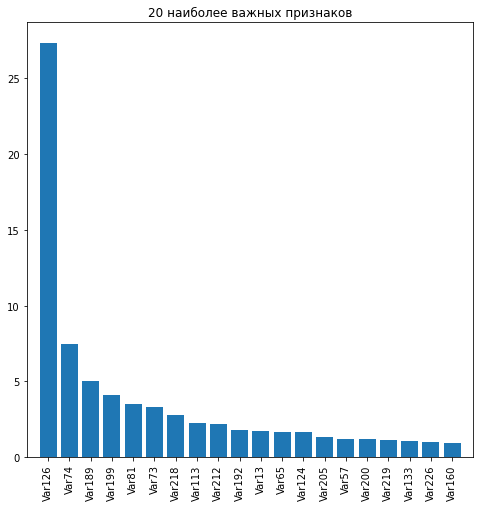

In [122]:
d_first = 20
plt.figure(figsize=(8, 8))
plt.title("20 наиболее важных признаков")
plt.bar(range(d_first), importances[indices[:d_first]], align='center')
plt.xticks(range(d_first), np.array(X.columns)[indices[:d_first]], rotation=90)
plt.xlim([-1, d_first]);

При нахождении наименее важных признаков обнаружил, что есть признаки, которые не вносят никакого вклада в модель. Попробуем удалить эти признаки и проверить качество классификации.

In [137]:
print('Число признаков, которые вносят ненулевой вклад в модель', (importances != 0).sum())

Число признаков, которые вносят ненулевой вклад в модель 98


In [138]:
important_features = X.columns[indices[:98]]

In [144]:
new_X = X[important_features]

In [147]:
cat_features = [c for c in new_X.columns if c in cat_col]

In [148]:
model = CatBoostClassifier(iterations=300,
                           learning_rate=0.1,
                           depth=2,
                           cat_features=cat_features,
                           verbose=False)

In [149]:
opt = GridSearchCV(model, param_grid={'class_weights': [class_weights, None]}, scoring='roc_auc', n_jobs=-1, cv=cv)

In [150]:
opt.fit(new_X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=<catboost.core.CatBoostClassifier object at 0x0000019D01D805B0>,
             n_jobs=-1,
             param_grid={'class_weights': [[0.5406890845694698,
                                            6.644153957879448],
                                           None]},
             scoring='roc_auc')

In [151]:
opt.best_params_

{'class_weights': [0.5406890845694698, 6.644153957879448]}

In [153]:
new_X_test = X_test[important_features]

In [154]:
ans = pd.DataFrame({'ID': data_test.ID,  'result': opt.predict_proba(new_X_test)[:, 1]})
ans.to_csv('kaggle.csv', index=False)
# Качество на тесте получилось 0.72098

Качество на тесте получилось хуже.

In [161]:
print('Признаки, которые имеют нулевой вес:')
for c in X.columns[indices[98:]]:
    if c != 'Var1':
        print(c, end=', ')
    else:
        print(c)

Признаки, которые имеют нулевой вес:
Var66, Var67, Var68, Var69, Var37, Var14, Var70, Var71, Var17, Var62, Var11, Var3, Var75, Var2, Var77, Var12, Var63, Var58, Var61, Var9, Var35, Var40, Var33, Var83, Var29, Var27, Var26, Var47, Var49, Var7, Var60, Var5, Var50, Var54, Var23, Var56, Var4, Var36, Var21, Var18, Var82, Var117, Var84, Var85, Var170, Var165, Var164, Var161, Var159, Var158, Var156, Var155, Var152, Var151, Var148, Var146, Var145, Var142, Var138, Var171, Var173, Var176, Var211, Var225, Var224, Var217, Var215, Var214, Var213, Var201, Var178, Var191, Var187, Var186, Var182, Var181, Var180, Var137, Var135, Var131, Var93, Var101, Var100, Var99, Var98, Var97, Var96, Var92, Var103, Var91, Var90, Var89, Var88, Var87, Var86, Var102, Var104, Var130, Var118, Var129, Var128, Var127, Var122, Var121, Var120, Var116, Var106, Var115, Var114, Var110, Var109, Var108, Var107, Var1


Как и было сказано выше, CatBoostLassifier способен извлечь нелинейные зависимости из, на первый взгляд, даже ненужных признаков

### 8\. Напоследок давайте посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли межу этими объектами что-то общее? Видны ли какие-либо закономерности? Предположите, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).

In [20]:
cat_features = [c for c in X.columns if c in cat_col]
model = CatBoostClassifier(iterations=300,
                           learning_rate=0.1,
                           depth=2,
                           cat_features=cat_features,
                           verbose=False)
opt = GridSearchCV(model, param_grid={'class_weights': [class_weights, None]}, scoring='roc_auc', n_jobs=-1, cv=cv)
opt.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=<catboost.core.CatBoostClassifier object at 0x000001C9C68CE400>,
             n_jobs=-1,
             param_grid={'class_weights': [[0.5406890845694698,
                                            6.644153957879448],
                                           None]},
             scoring='roc_auc')

In [21]:
result = pd.DataFrame({'probability': opt.predict_proba(X)[:, 1], 'labels': y})

За ошибку будем считать отнесение к классу +1 тех объектов, вероятность которых меньше 0.1 и отнесение к классу -1 тех объектов, вероятность которых больше 0.9

In [22]:
error = result[((result.probability > 0.9) & (result.labels == -1)) | 
               ((result.probability < 0.1) & (result.labels == 1))]

In [215]:
error_1 = result[((result.probability > 0.9) & (result.labels == -1))] # ошибка первого рода
error_2 = result[((result.probability < 0.1) & (result.labels == 1))] # ошибка второго рода

Посмотрим на эти объеты:

In [208]:
top10 = X.columns[indices[:10]]

In [220]:
X.iloc[error_1.index][top10]

,Var126,Var74,Var199,Var189,Var212,Var81,Var73,Var218,Var113,Var13
602,0.0,0.0,msIvIpku4g,0.0,NhsEn4L,167007.90,36,NA,-105843.6,0.0
6984,-10.0,0.0,kmL8CT_,102.0,NhsEn4L,40493.70,14,NA,-103952.0,0.0
7029,0.0,0.0,nQUX8Hg64f,150.0,NhsEn4L,268313.40,16,NA,-491748.0,0.0
7267,0.0,0.0,NfN9Bz6HFx,264.0,NhsEn4L,112778.40,26,NA,176358.0,0.0
9118,-8.0,0.0,UFIdC8I,0.0,NhsEn4L,178916.10,16,UYBR,2608976.0,0.0
9691,0.0,42.0,fTvO8qD,0.0,NhsEn4L,80874.91,60,NA,279472.4,492.0
9936,0.0,0.0,d4Gf64d6X6,0.0,NhsEn4L,136331.40,28,NA,-174197.6,0.0
10197,0.0,56.0,Gx4DdKpk3W4UA,0.0,NhsEn4L,15844.20,58,NA,58630.0,48.0
11335,-10.0,0.0,7vJNLJ0,192.0,NhsEn4L,11831.91,14,cJvF,1261200.0,0.0
12899,-10.0,0.0,NW71mrodGH,0.0,NhsEn4L,207157.80,14,NA,363336.0,0.0


In [224]:
X.iloc[error_2.index][top10]

,Var126,Var74,Var199,Var189,Var212,Var81,Var73,Var218,Var113,Var13
3152,-30.0,161.0,nQUq7hGe64,294.0,XfqtO3UdzaXh_,4513.29,58,UYBR,13988.16,1304.0
3216,-30.0,14.0,3clyC8L,0.0,WsRVNrF85oPU_,113647.80,64,UYBR,144296.00,1384.0
3224,-26.0,63.0,MypvvoIQqc,0.0,4kVnq_T26xq1p,20975.91,160,cJvF,51163.20,228.0
4309,-30.0,175.0,n1zVHpT8NN,0.0,Ie_5MZs,20317.98,164,cJvF,53568.00,4712.0
7814,-26.0,231.0,WN2wUb0T0UKRa,0.0,leSl,29408.46,154,cJvF,262702.00,3884.0
15321,-18.0,637.0,3cO76t0,0.0,Ie_5MZs,3244.29,136,UYBR,-1849496.00,2900.0


Можно предположить причину того, что объекты неправильно классифицируются по наиболее важным признакам. Ошибка второго рода достигается, если признак Var126 принимает отрицательные значения < -17. Ошибка первого рода достигается, если признак Var212 принимает значение "NhsEn4L". Также можно предположить, что ошибка первого рода может возникнуть из-за большого количества пропусков.

Попробуем удалить эти объекты.

In [27]:
new_X = X.drop(error.index, axis=0)

In [28]:
new_y = y.drop(error.index)

In [29]:
opt.fit(new_X, new_y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=<catboost.core.CatBoostClassifier object at 0x000001C9C68CE400>,
             n_jobs=-1,
             param_grid={'class_weights': [[0.5406890845694698,
                                            6.644153957879448],
                                           None]},
             scoring='roc_auc')

In [244]:
ans = pd.DataFrame({'ID': data_test.ID,  'result': opt.predict_proba(X_test)[:, 1]})
ans.to_csv('kaggle.csv', index=False)
# Качество на тесте получилось 0.72582

Качество на тесте улучшилось

### 9\. По итогам проведенных экспериментов постройте финальную решение - модель с наилучшим качеством. Укажите, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.
Итоговая модель построена на предыдущем шаге. По результатам экспериментов было выявлено следующее:
1. Для обучения модели требуется вся обучающая выборка;
2. В качестве борьбы с дисбаланасом классов используются веса объектов:
   $$ weight_1 = n / 2n_1 $$
   $$ weight_0 = n / 2n_0, $$
   где $$weight_1 - вес \ объектов \ churn$$
   $$weight_0 - вес \ объектов \ not \ churn$$
   $$n - число \ объектов$$
   $$n_1 - число \ объектов \ класса \ churn$$
   $$n_0 - число \ объектов \ класса \ not \ churn$$
3. Пропуски заполняются по следующей стратегии: пропуски у числовых признаков заполняются нулями, а у категориальных - новой категорией "NA"
4. Категориальные признаки обрабатываются автоматически с помощью алгоритма CatBoostClassifier
5. Отбор признаков: удалить только те признаки, которые имеют пропуски на всех объектах
6. С помощью GridSearchCV подобрали оптимальные параметры для CatBoostClassifier: depth=2 и learning_rate=0.1
7. Удалить те объекты, которые имеют "наибольшую" ошибку.

### 10\. Подумайте, можно ли еще улучшить модель? Что для этого можно сделать? 

In [23]:
poor_obj = data_train.count(axis=1)[data_train.count(axis=1) < 53].index

In [32]:
X_2 = new_X.drop(poor_obj, axis=0)

In [33]:
y_2 = new_y.drop(poor_obj)
opt.fit(X_2, y_2)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=<catboost.core.CatBoostClassifier object at 0x000001C9C68CE400>,
             n_jobs=-1,
             param_grid={'class_weights': [[0.5406890845694698,
                                            6.644153957879448],
                                           None]},
             scoring='roc_auc')

In [36]:
ans = pd.DataFrame({'ID': data_test.ID,  'result': opt.predict_proba(X_test)[:, 1]})
ans.to_csv('kaggle.csv', index=False)
# Качество на тесте получилось 0.72587

Здесь произошла очередная чистка данных, удалились те объекты, которые изначально имели меньше 53 заполненных значений.